# Evaluating Classic Controllers

This tutorial demonstrates Myriad's evaluation API for non-learning agents. You'll learn:
- How to configure and run evaluations using `create_eval_config()` and `evaluate()`
- How to capture episode data for rendering and analysis
- How to compare agent performance across multiple rollouts

We'll evaluate three controllers on the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/) swing-up task — the pole starts hanging down and the goal is to swing it upright:
- **Random**: applies random torque each step
- **Bang-Bang**: a damping controller that applies maximum torque opposing the angular velocity
- **PID**: a proportional controller that smoothly damps angular velocity

In [1]:
import matplotlib.pyplot as plt

from myriad import create_eval_config, evaluate
from myriad.utils.rendering import render_episodes

from _helpers import side_by_side_videos


## Run Evaluations

Myriad's evaluation workflow has two steps:
1. **Configure**: `create_eval_config()` builds an immutable config specifying the environment, agent, and evaluation settings
2. **Execute**: `evaluate(config)` runs parallel rollouts and returns summary statistics

Agent-specific parameters (like `obs_field`, `kp`) are passed as flat kwargs — Myriad automatically routes them to the agent configuration.

We evaluate each agent over 50 rollouts with `return_episodes=True`. This captures both summary statistics (mean return, std) AND raw episode data (observations, actions, rewards) needed for rendering videos later.

In [2]:
agents = {
    "Random": dict(agent="random"),
    "Bang-Bang": dict(agent="bangbang", obs_field="theta_dot", setpoint=0.0, invert=True),
    "PID": dict(agent="pid", obs_field="theta_dot", setpoint=0.0, kp=1.0, dt=0.05),
}

results = {}
episodes = {}

for label, kwargs in agents.items():
    config = create_eval_config(env="pendulum-control", eval_rollouts=50, seed=0, **kwargs)
    results[label] = evaluate(config, return_episodes=True)
    # Store first episode for rendering
    episodes[label] = {k: v[0] for k, v in results[label].episodes.items()}
    print(f"{label}: {results[label]}\n")

Random: EvaluationResults(
  mean_return=-617.4 ± 426.7,
  range=[-1415.9, -11.4],
  mean_length=200.0,
  num_episodes=50
)

Bang-Bang: EvaluationResults(
  mean_return=-83.8 ± 174.7,
  range=[-986.1, -1.7],
  mean_length=200.0,
  num_episodes=50
)

PID: EvaluationResults(
  mean_return=-51.0 ± 59.5,
  range=[-268.2, -0.3],
  mean_length=200.0,
  num_episodes=50
)



## Compare Results

The `EvaluationResults` object contains summary statistics across all rollouts:
- `mean_return`, `std_return`: Performance metrics (higher is better)
- `mean_length`: Average episode length
- `episodes`: Raw episode data (when `return_episodes=True`)

Let's plot mean return with standard deviation error bars. Higher (less negative) is better — the pendulum reward penalizes distance from upright and torque magnitude.

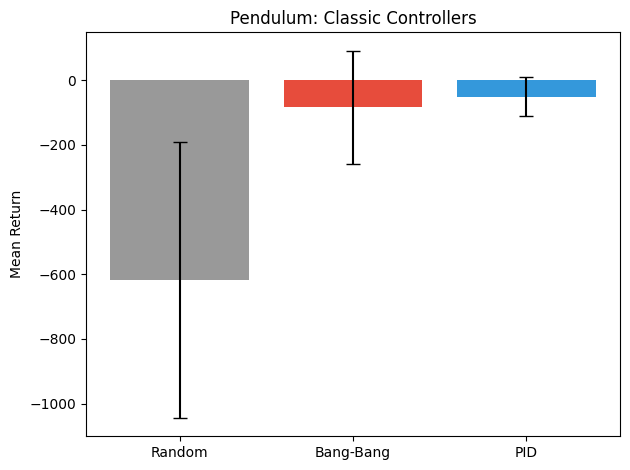

In [3]:
names = list(results.keys())
means = [results[n].mean_return for n in names]
stds = [results[n].std_return for n in names]

plt.bar(names, means, yerr=stds, capsize=5, color=["#999", "#e74c3c", "#3498db"])
plt.ylabel("Mean Return")
plt.title("Pendulum: Classic Controllers")
plt.tight_layout()
plt.show()

## Render Videos

Use the saved episodes to generate videos for each agent.

In [4]:
video_paths = []
video_labels = []

for label, episode in episodes.items():
    agent_name = agents[label]["agent"]
    path, _ = render_episodes(
        episode=episode,
        env_name="pendulum-control",
        output_path=f"videos/pendulum_{agent_name}.mp4",
        fps=20,
    )
    video_paths.append(path)
    video_labels.append(label)

side_by_side_videos(video_paths, video_labels, width=300)